In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from numpy.random import choice, rand 
import itertools
%matplotlib inline

In [3]:
def compute_list_avg(list_to_avg):
    total = [sum(x) for x in zip(*list_to_avg)]
    den = len(list_to_avg)
    avg = [x/den for x in total]
    return avg

## Definition of the graph

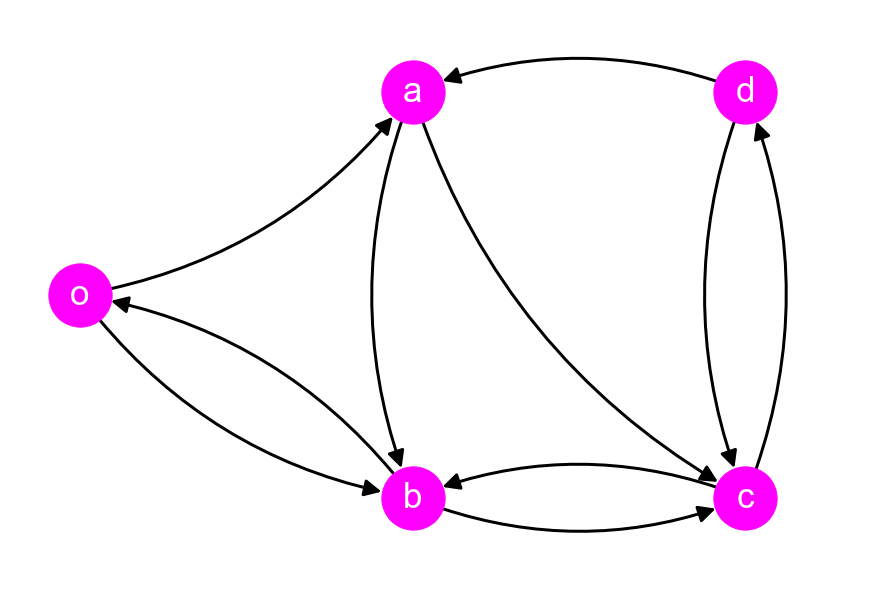

In [56]:
fig = plt.figure(1, figsize=(12,8))

G = nx.MultiDiGraph()

G.add_node('o')
G.add_node('a')
G.add_node('b')
G.add_node('c')
G.add_node('d')

G.add_edges_from([('o', 'a'), ('o', 'b'), ('b', 'o'), ('a', 'b'), ('d', 'a'),
                  ('a', 'c'), ('b', 'c'), ('c', 'd'), ('c', 'b'), ('d', 'c')])

pos = {'o':[-2, 0], 'a':[0, 2], 'b':[0, -2], 'c':[2, -2], 'd':[2, 2]}

n_nodes = G.number_of_nodes()

nx.draw(G, pos, with_labels = True, font_color='white', node_color='magenta', 
        edge_color='black', node_size=4000, font_size=35, width=3, arrowsize=35,
       connectionstyle='Arc3, rad = 0.2')

## Problem 1

Given the following transition rate matrix Lambda:

In [57]:
Lambda = [
[   0, 2/5, 1/5,   0,   0],
[   0,   0, 3/4, 1/4,   0],
[ 1/2,   0,   0, 1/2,   0],
[   0,   0, 1/3,   0, 2/3],
[   0, 1/3,   0, 1/3,   0]
]

Your task is to simulate the particle moving around in the network in continuous time according
to the transition rate matrix Lambda.

The rows do not sum up to 1, this is not a stochastic matrix because this does not describe the probability immediately. In the discrete case the matrix describes the probability of jump in the neighbor, now we do not use this directly, we use the matrix Q and P to compute the probabilities, of course they are determined by $\Lambda_{ij}$ but this is not immediately the probability matrix for the jumps.

Concerning the **probability distribution of the CTMC**, we have seen in the **discrete case** we said that if we describe the **position of the random walker** with a random variable, then the **probability distribution** of the position in time **evolves** according to the **flow dynamics**. Now there is something similar: if we describe the **probability distribution of the CTMC** with this vector $\bar{\pi}(t)$  this is the **probability of being in some position at time t**, **each entry of $\bar{\pi}(t)$ gives the probability distribution of being in that node at time t**. The difference is that now time is continuous.

But if we describe this probability distribution as a vector, then the **probability vector evolves** according to an equation again which is not the flow dynamics but it is a **differential equation**.
Before we had a vector describing probabilities evolving in time according to the flow dynamics, now we have a **vector describing the probabilities that evolves in time according to a differential equation**.

The probability distribution $\bar{\pi}(t)$ of the CTMC $X(t)$ with transition rate matrix $\Lambda$ evolves according to the equation

$$
\frac{d}{dt} \bar{\pi}(t) = -L'\bar{\pi}(t)
$$

where $L= diag(w) - \Lambda$, with $w = \Lambda \mathbf{1}$.

Thus, **invariant probability vector** are eigenvector of $L'$ corresponding to eigenvalue $0$. 

Also here we can define what are the **invariant probability distributions**:
- **Discrete case**: leading eigenvectors of P
- **Continuous case**: vectors such that $L'\bar{\pi}$ = 0, L is the laplacian matrix of the graph


The **invariant probability distribution** describes a distribution of states of our process that is invariant in time, it **doesn't evolve**, it stays the same. We can **compute it** using the **leading eigenvectors of Q'**.

**Compute the invariant probability vector $\bar{\pi}$ of the CTMC by determining the leading eigenvector of the matrix $Q'$**

It can also be proven that $\bar{\pi}$ is the left dominant eigenvector of $Q$, where $Q$ is defined as:

$$
Q_{ij} = \frac{\Lambda_{ij}}{\omega_{*}}, \; i \neq j \quad Q_{ii} = 1 - \sum_{i \neq j} Q_{ij}
$$

where:
- $\omega_{i}$ is the **sum of of each row $i$ of the matrix $\Lambda$**. 
- $\omega_{*}=\max_i \omega_i$ is the maximum between the $\omega_{i}$. 

To obtain the matrix **Q** we **divide the matrix $\Lambda$ with the maximum row sum $\omega_{*}$** and we **add** on the **diagonal 1 - the sum of the value on the row**. 

**Q is the matrix describing the jumps, so it has to sum up to 1 on rows**. This is completely determined by lambda, all the information are contained in lambda, which is good since lambda is the only data we have in the problem.

In [58]:
# omega_i, sum of the rows of lambda, the rate of the clocks in the second approach.
w = np.sum(Lambda, axis=1) 
# omega_star, the maximum of omega_i
w_star = np.max(w) 
# define matrix Q as lambda/omega_star, this is true outside the diagonal.
Q = Lambda/w_star 
# add the diagonal part, 1 minus the sum of the rows of Q.
Q = Q + np.diag(np.ones(len(w))-np.sum(Q,axis=1))
print('matrix Q:')
print(Q)
print()
print(f'Omega w_i')
print(w)

matrix Q:
[[0.4        0.4        0.2        0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.33333333 0.         0.66666667]
 [0.         0.33333333 0.         0.33333333 0.33333333]]

Omega w_i
[0.6        1.         1.         1.         0.66666667]


In [59]:
# Compute the eigenvalue and the eigenvectors
values,vectors = np.linalg.eig(Q.T)
#Identify the leading one and we print it.
index = np.argmax(values.real)
# pi_bar is the invariant measure of the CTMC
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)

# Print probability of each state
print("pi_bar=", pi_bar)

pi_bar= [0.18518519 0.14814815 0.22222222 0.22222222 0.22222222]


In [60]:
# contruct the P matrix 
# omega is the sum of the rows of lambda, these are the rates of each clock.
w = np.sum(Lambda, axis=1)
D = np.diag(w)  # diagonal matrix with the rates on the diagonal
# The matrix P is D^-1 @ Lambda, we will use P for the probability of jumps.
P = np.linalg.inv(D) @ Lambda

### a) What is, according to the simulations, the average time it takes a particle that starts in node a to leave the node and then return to it?

We need to simulate the continuous-time Markov chain.

In this case we choose the approach where we use a **global clock with rate $\omega^* = \max_i{\omega_i}$** and the **conditional probability matrix $Q$**.

**Conditional** because tells you the **probability** of the **transition conditioning to the fact that you already are in the starting node**. You are in i, you can make a jump in j but this depends on the fact that you are in i.

To simulate continuous time Markov chains the following fact will be useful.
To **simulate a Poisson clock with rate $r$**, one must **simulate the time between two consecutive ticks**, which we denote $t_{next}$. We can compute $t_{next}$ as
$$ t_{next} = - \frac{\ln(u)}{r}$$
where $u$ is a random variable with uniform distribution, $u \in \mathcal{U}(0,1)$.

I define a function to compute the return time if the starting node is the same or the hitting time if the end node is different from the starting one.

In [61]:

def return_time(start, end):
    # Approach: local clocks with rates w_i and matrix P

    # transition_times will store the time instants at which transitions happen
    transition_times = []

    # DIFFERENCE IS HERE: How to compute the time to wait for the next transition, the next tick of the clock.

    # the random time to wait for the next transition is drawn according to its distribution.
    # NOTE: in the formula for t_next we use the rate of the clock of the current state, in this case w[1].
    # The rate of the clock is the rate of the clock in the CURRENT position.
    t_next = -np.log(np.random.rand())/w[1]

    # DIFFERENCE IS HERE: The probability of visiting the next node is described by the matrix P, not Q.
    # We want to extract the next neighboring node visited according to the probability distribution
    # described by the row of P corresponding to the current position i-1.
    # Then we compute the cumulative sums of the rows of P and we use the same procedure.
    P_cum = np.cumsum(P, axis=1)

    current_node = start

    #print(start)
    while True:
        # the next state to visit will be extracted according to the probabilities
        # stored in the row of P corresponding to the current state.
        # Look at the smallest index where the cumulative sum is greater than a random number U(0,1).
        neighbor = np.argwhere(P_cum[current_node] > np.random.rand())[0]
        #print(neighbor)
        
        # store the time instant of the current transition
        if len(transition_times)==0:
            transition_times.append(t_next)
        else:
            transition_times.append((transition_times[-1] + t_next)[0])
        
        # compute the waiting time to the next transition
        # NOTE: we use the rate w[pos[i]] of the clock of the current position
        # we use the clock of position i!
        t_next = -np.log(np.random.rand())/w[neighbor]
              
        if neighbor[0] == end:
            # I returned to the starting point or I hit the end node
            return transition_times

        current_node = neighbor[0]

In [62]:
def avg_return_time(start, end, n_steps=100):
    
    times = []
    for i in range(n_steps):
        times.append(return_time(start,end)[-1])
        
    return sum(times)/len(times)

ret_time_a_sim = avg_return_time(1, 1, 10000) # with 500.000 we reach approximately the same number
print(ret_time_a_sim)

6.753336563198761


### b) How does the result in a) compare to the theoretical return-time $E_a[T^{+}_{a}]$? (Include a description of how this is computed)

The expected return time in a continuous Markov Chain is defined as:

$$E_a[T^{+}_{a}] = \frac{1}{\omega_a \bar{\pi_a}} $$

Now we can look at the vector $w_i$ at the position 1 which corresponds to the node a:

$\omega_a = 1$

And we can look at the vector $\bar{\pi_i}$ at the position 1 which corresponds to the node a:

$\bar{\pi_a} = 0.14814815$

Now we can compute the theoretical return time $E_a[T^{+}_{a}]$ and compare it with the simulated result.

In [63]:
ret_time_a_theo = 1/(w[1]*pi_bar[1])
print("Theoretical return time in node a: ", ret_time_a_theo)
print("Simulated return time in node a: ", ret_time_a_sim)

Theoretical return time in node a:  6.749999999999999
Simulated return time in node a:  6.753336563198761


### c) What is, according to the simulations, the average time it takes to move from node o to node d?

In [64]:
hit_time_od_sim = avg_return_time(0, 4, 100000) # set to 500000 
print(hit_time_od_sim)

8.095828929573045


### d) How does the result in c) compare to the theoretical hitting-time $E_o[T^{+}_{d}]$? (Describe also how this is computed.) !da rivedere, soprattutto in base al sistema di equazioni da risolvere!

The expected hitting time is defined by the following formula:
$$ E_o[T^{+}_{d}] = \frac{1}{w_o} + \sum_{j} P_{oj} \mathbb{E}_j[T_d] $$
where $P_{dj} = \frac{\Lambda_{dj}}{\omega_{d}}$

The formula means that the **expected hitting time from the node o to d** is given by the sum between:
1. The **expected time** $\frac{1}{w_o}$ to **jump out to the node o**.
2. The **sum** of the **expected hitting time from $j$**, the **out-neighbors of $o$**, **to reach $S$**, the final target (the node d) **weighted** for the **probability to jump into $j$** from **$o$** at time $\frac{1}{w_o}$.

P is the **normalized weight matrix** defined as
$$ P = diag(\omega)^{-1} \Lambda$$

In [65]:
#D = np.diag(w)
#P = np.linalg.inv(D) @ Lambda
P

array([[0.        , 0.66666667, 0.33333333, 0.        , 0.        ],
       [0.        , 0.        , 0.75      , 0.25      , 0.        ],
       [0.5       , 0.        , 0.        , 0.5       , 0.        ],
       [0.        , 0.        , 0.33333333, 0.        , 0.66666667],
       [0.        , 0.5       , 0.        , 0.5       , 0.        ]])

The expected hitting times  $\hat{x}= (\mathbb{E}_i[T_S])_{i \in R}$ for the set $S$ and for all nodes $i \in R = \mathcal V \setminus S$ can be computed by solving the system of equations

$$
\hat{x} = \mathbf{1} + \hat{P}\hat{x},
$$ 

where $\hat{P}$ is obtained from $P$ (the **normalized weight matrix of the graph**) by **removing the rows and columns corresponding to the nodes in the set $S$**.

More explicitly, the expected hitting times can be expressed as

$$
\hat{x} = (I - \hat{P})^{-1} \mathbf{1}
$$

**Remark**: note that $(I - \hat{P})$ **is invertible if and only if** $V \setminus S$ has **at least a link pointing to $S$**. Indeed, if $(I - \hat{P})$ is not invertible, the random walk starting from nodes in $\mathcal V \setminus S$ cannot hit nodes in $S$, and the hitting time explode.


The set $S$ that we want to hit is the node $d$:

$S = \{d\}$

$R = \{a, b \}$

The **initial node** $o$ has **2 neighbors**: the **node $a$** and the **node $b$**. We need to compute for these 2 node the expected hitting time to reach node $d$.

We can compute the hitting time of all the nodes to reach $d$ and pick only the two related to node a and node b.

In [66]:
S = [4]
R = [node for node in range(n_nodes) if node not in S]
print("nodes in R: ", R)
# Restrict P to R x R to obtain hat(P)
hatP = P[np.ix_(R, R)] # you give the 2 sets of nodes to which you want to restict.
print()
print("hatP:")
print(hatP)

# I need to define the two starting points

# solve the linear system to obtain hat(x)
# np.linalg.solve solves a linear matrix equation given
# the coefficient matrix and the dependent variable values
hatx = np.linalg.solve((np.identity(n_nodes-1)-hatP),np.ones(n_nodes-1))
print()
print("hatx:", hatx)


# map node to position of node in hatx,
# in this case is specified even if not necessary since the nodes are in order.
map = {0: 0, 1: 1, 2: 2, 3: 3}

# define the hitting times to the set S
# hitting time is 0 if the starting node is in S
hitting_s = np.zeros(n_nodes)
# hitting time is hat(x) for nodes in R
for r in R:
    hitting_s[r] = hatx[map[r]]

print()
print("hitting times:", hitting_s)

nodes in R:  [0, 1, 2, 3]

hatP:
[[0.         0.66666667 0.33333333 0.        ]
 [0.         0.         0.75       0.25      ]
 [0.5        0.         0.         0.5       ]
 [0.         0.         0.33333333 0.        ]]

hatx: [7.35714286 6.42857143 6.21428571 3.07142857]

hitting times: [7.35714286 6.42857143 6.21428571 3.07142857 0.        ]


let's implement the formula to compute the expected hitting time from o to d:

$$ E_o[T^{+}_{d}] = \frac{1}{w_o} + \sum_{j} P_{oj} \mathbb{E}_j[T_d] =$$
$$=\frac{1}{w_o} + P_{oa} \mathbb{E}_a[T_d] + P_{ob} \mathbb{E}_b[T_d] $$


In [67]:
hit_a_d = hitting_s[1]
hit_b_d = hitting_s[2]
P_o_a = P[0,1]
P_o_b = P[0,2]

#print(P_o_a, hit_a_d, P_o_b, hit_b_d)

expect_hit_o_d = (1/w[0]) + (P_o_a*hit_a_d) + (P_o_b*hit_b_d)

print("Theoretical expected hitting time from node o to d: ", expect_hit_o_d)
print("Simulated expected hitting time from node o to d: ", hit_time_od_sim )

Theoretical expected hitting time from node o to d:  8.023809523809522
Simulated expected hitting time from node o to d:  8.095828929573045


**Question**: what are the conditions under which the dynamics converges to consensus?

**Theorem**: assume that
- its condensation graph has 1 sink;
- the sink component of the graph is aperiodic;

Then,

$$
\lim_{t \to +\infty} x(t) = \alpha \mathbf{1},
$$

i.e., the agents get to consensus, the consensus value is $\alpha$.

Let $G$ be a graph such that $s_G$ = 1 and the **connected component** of $G$ corresponding to the **unique sink** of its condensation graph is **aperiodic**.

Let $P$ be the normalized weight matrix of $G$ and let $\pi = P'\pi$ be its unique invariant probability. Then, the discrete-time averaging dynamics satisfies:

$$
\lim_{t \to + \infty}x(t) = \alpha \mathbb{1}, \quad \alpha = \pi'x(0)
$$

## !!! How to compute the initial variance in the graph? !!!

### e) Interpret the matrix $\Lambda$ as the weight matrix of a graph $\mathcal{G} = (\mathcal{V}, \xi, W)$, and simulate the French-DeGroot dynamics on $\mathcal{G}$ with an arbitrary initial condition x(0). Does the dynamics converge to a consensus state? Motivate your answer.

We need to check if the original graph $\mathcal{G}$ is **strongly connected** and **aperiodic**. If it is the conditions of the **French-DeGroot** theorem are satisfied we are sure that the vector of opinions will **converge** to a **consensus vector**.

In [68]:
print("Is G aperiodic:",nx.is_aperiodic(G))
print("Is G strongly connected:",nx.is_strongly_connected(G))

Is G aperiodic: True
Is G strongly connected: True


{0: {'members': {'a', 'b', 'd', 'c', 'o'}}}


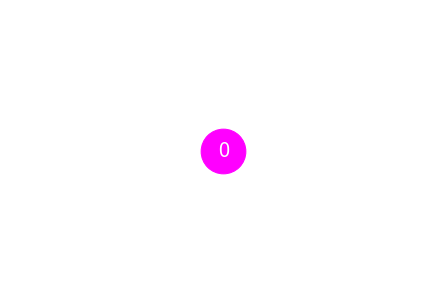

In [69]:
CG = nx.algorithms.components.condensation(G)
nx.draw(CG, with_labels=True, node_size=2000, font_color='white', 
        font_size=20, width=3, arrowsize=35, node_color='magenta')

print(dict(CG.nodes))

The consensus $\alpha$ is defined as:

$\lim_{t \rightarrow \infty} x(t) = \alpha \mathbb{1} \quad$ where 
$\quad \alpha = \pi' x(0) = \sum_{k} \pi_{k} x_{k}(0)$

$\alpha = \pi' x(0)$ can be interpreted as the **original opinions $x_{k}(0)$** **weighted** by the **invariant distribution centrality $\pi_{k}$**.


In [70]:
x = np.random.rand(5)
print(x)

for n in range(1000):
    x = P @ x
print("consensus vector (alpha): ", x, "\n")

[0.6816338  0.67690694 0.16877964 0.95765917 0.14049704]
consensus vector (alpha):  [0.52491957 0.52491957 0.52491957 0.52491957 0.52491957] 



Since the condition of the French-DeGroot theorem are satisfied we are able to reach consensus with any arbitrary condition $x(0)$. In this case since the graph is strongly connected all the initial opinions are valuable and contribute to consensus.

### f) Assume that the initial state of the dynamics for each node $i \in \mathcal{V}$ is given by $x_{i}(0) = \xi_i$ , where $\{ \xi_i \}_{i \in \mathcal{V}}$ are i.i.d random variables with variance $\sigma^2$. Compute the variance of the consensus value, and compare your results with numerical simulations.

A typical assumption is that the noises $\xi_i$ are **independent** and with the **same variance** $\sigma^2$. The variance of the asymptotic consensus $\alpha$ is:

$$
\sigma_{\alpha}^{2} = \sigma^{2} \sum_{i} \pi^{2}_{i}
$$


Let's consider for sake of simplicity $\sigma^{2} = 1$, then we take the original pi, we take the power 2 of each number and we sum it.

In [71]:
variance_init = 1
sigma_pi_bar_consensus = sum(pi_bar**2)*variance_init
print("Ratio between consensus variance and original variance:")
print(sigma_pi_bar_consensus)

Ratio between consensus variance and original variance:
0.20438957475994515


The variance of the consensus vector $\sigma_{\alpha}^{2}$ should be more or less 1/5 of the original variance (consensus variance = original variance * 0.20)

In [72]:
# start with random initial states and run the dynamics
def compute_variance(P, n=800):
    orig_variance = np.zeros(n)
    alfa_err = np.zeros(n)

    for i in range(n):
    # rand returns random values in [0,1], thus \mu = 1/2
        x = np.random.rand(5)
        initial_distrib = x
        for n in range(500):
            x = P @ x
        #print(x)
        alfa_err[i] = (1/2 - np.mean(x))*(1/2 - np.mean(x))
        
        # I take the variance of the original single opinions
        tmp = 0
        for u in initial_distrib:
            tmp += (u-0.5)**2
        orig_variance[i] = tmp/5
        
    return np.mean(orig_variance), np.mean(alfa_err), initial_distrib, x
    
avg_var_init, avg_var_cons, initial_distrib, x = compute_variance(P, 1000)
print("Variance of the initial node states:", avg_var_init)
print("Variance of the consensus state:", avg_var_cons)
print("Consensus variance / original variance", avg_var_cons/avg_var_init) # ?? to be checked -> should be fine

Variance of the initial node states: 0.08440565056539989
Variance of the consensus state: 0.01726225005258533
Consensus variance / original variance 0.2045153367926481


In [73]:
# dubbi sul calcolo della varianza originale -> should be fine

### g) Remove the edges (d; a) and (d; c). 

### Describe and motivate the asymptotic behaviour of the dynamics. If the dynamics converges to a consensus state, how is the consensus value related to the initial condition $x(0)$? 

### Assume that the initial state of the dynamics for each node $i \in \mathcal{V}$ is given by $x_{i}(0) = \xi_i$ , where $\{ \xi_i \}_{i \in \mathcal{V}}$ are i.i.d random variables with variance $\sigma^2$. Compute the variance of the consensus value. Motivate your answer.

You cannot obtain an invariant distribution equal to 0. If **one entry** in **D matrix** is **0**, then this **matrix D** could **not be inverted**, the **matrix P** is **not defined** when you have **isolated node** or **sink node**, so **nodes without outgoing links**. In this case **P cannot be defined**, so you can **take the sink node** and **add a self-loop**, which correspond to **1** to the **entry D**. In this way we can study the problem.

In [74]:
Lambda2 = [
[   0, 2/5, 1/5,   0,   0],
[   0,   0, 3/4, 1/4,   0],
[ 1/2,   0,   0, 1/2,   0],
[   0,   0, 1/3,   0, 2/3],
[   0,   0,   0,   0,   1] # I have to add a self loop in order to compute P
]

In [75]:
# omega_i, sum of the rows of lambda, the rate of the clocks in the second approach.
w2 = np.sum(Lambda2, axis=1) 
# omega_star, the maximum of omega_i
w2_star = np.max(w2) 
# define matrix Q as lambda/omega_star, this is true outside the diagonal.
Q2 = Lambda2/w2_star 
# add the diagonal part, 1 minus the sum of the rows of Q.
Q2 = Q2 + np.diag(np.ones(len(w2))-np.sum(Q2,axis=1))
print('matrix Q2:')
print(Q2)
print()
print(f'Omega w2_i')
print(w2)

matrix Q2:
[[0.4        0.4        0.2        0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.33333333 0.         0.66666667]
 [0.         0.         0.         0.         1.        ]]

Omega w2_i
[0.6 1.  1.  1.  1. ]


In [76]:
# Compute the eigenvalue and the eigenvectors
values2,vectors2 = np.linalg.eig(Q2.T)
#Identify the leading one and we print it.
index2 = np.argmax(values2.real)
# pi_bar is the invariant measure of the CTMC
pi_bar2 = vectors2[:,index2].real
pi_bar2 = pi_bar2/np.sum(pi_bar2)

# Print probability of each state
print("pi_bar2=", pi_bar2)
print()

D2 = np.diag(w2) 
print("D2=")
print(D2)
print()
P2 = np.linalg.inv(D2) @ Lambda2
print("P2=")
print(P2)


pi_bar2= [0. 0. 0. 0. 1.]

D2=
[[0.6 0.  0.  0.  0. ]
 [0.  1.  0.  0.  0. ]
 [0.  0.  1.  0.  0. ]
 [0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  1. ]]

P2=
[[0.         0.66666667 0.33333333 0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.33333333 0.         0.66666667]
 [0.         0.         0.         0.         1.        ]]


Is G aperiodic: True
Is G strongly connected: False


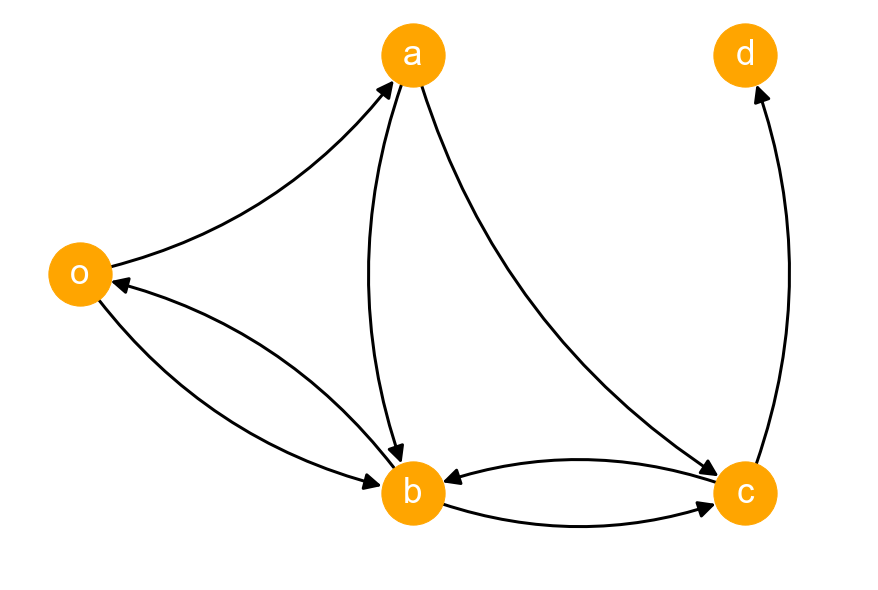

In [77]:
fig = plt.figure(1, figsize=(12,8))

G2 = G.copy()

G2.remove_edge('d', 'a')
G2.remove_edge('d', 'c')

print("Is G aperiodic:",nx.is_aperiodic(G2))
print("Is G strongly connected:",nx.is_strongly_connected(G2))

nx.draw(G2, pos, with_labels = True, font_color='white', node_color='orange', 
        edge_color='black', node_size=4000, font_size=35, width=3, arrowsize=35,
        connectionstyle='Arc3, rad = 0.2')

{0: {'members': {'d'}}, 1: {'members': {'o', 'a', 'c', 'b'}}}


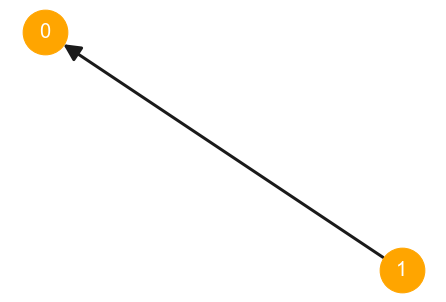

In [78]:
CG2 = nx.algorithms.components.condensation(G2)
nx.draw(CG2, with_labels=True, node_size=2000, font_color='white', 
        font_size=20, width=3, arrowsize=35, node_color='orange')

print(dict(CG2.nodes))

In this case the graph is **aperiodic** but it is **not strongly connected**, we have one sink composed by the node d.

If the graph is **not strongly connected**, but still its **condensation graph** has **one sink** which is still **aperiodic**, the **averaging dynamics** converges to a **consensus**, whose value depends only on the **initial state of nodes of the sink**;


In [79]:
avg_var_init2, avg_var_cons2, init, cons = compute_variance(P2, 800)
print("Initial distribution:", init)
print("Consensus vector:", cons)
print("Variance of the initial node states:", avg_var_init2)
print("Variance of the consensus state:", avg_var_cons2)
print("Consensus variance / original variance", avg_var_cons2/avg_var_init2)

Initial distribution: [0.58130945 0.90982075 0.85190099 0.95839877 0.39373585]
Consensus vector: [0.39373585 0.39373585 0.39373585 0.39373585 0.39373585]
Variance of the initial node states: 0.0828424074647214
Variance of the consensus state: 0.08280235687880237
Consensus variance / original variance 0.9995165448814838


The **consensus vector** has **all values equal** to the **initial condition** of the **node d**, the **sink node**!

### h) Consider the graph $(\mathcal{V}, \xi, \Lambda)$, and remove the edges $(c, b)$ and $(d, a)$. 

### Analyse the French-DeGroot dynamics on the new graph. In particular, describe and motivate the asymptotic behaviour of the dynamics in terms of the initial condition $x(0)$.

Is G aperiodic: True
Is G strongly connected: False


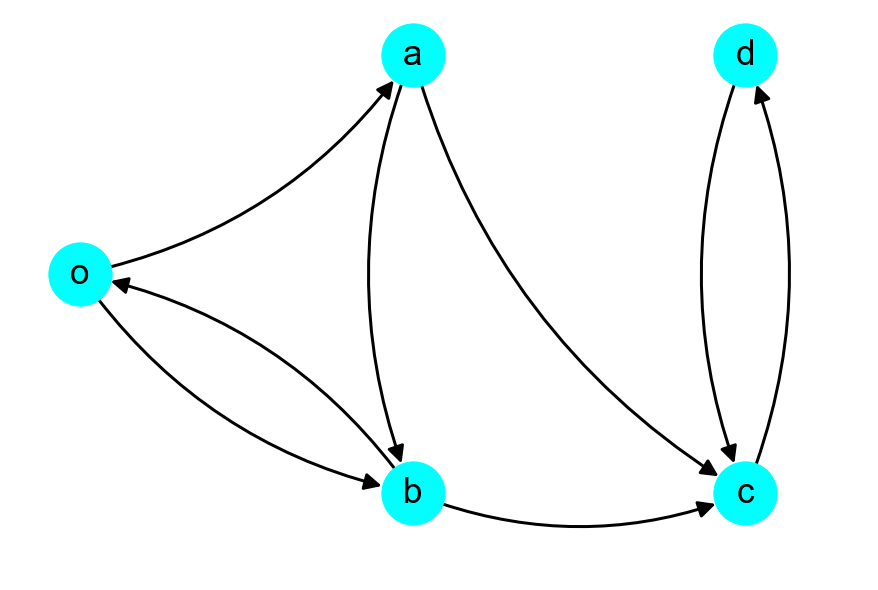

In [80]:
fig = plt.figure(1, figsize=(12,8))

G3 = G.copy()

G3.remove_edge('c', 'b')
G3.remove_edge('d', 'a')

print("Is G aperiodic:",nx.is_aperiodic(G3))
print("Is G strongly connected:",nx.is_strongly_connected(G3))

nx.draw(G3, pos, with_labels = True, font_color='black', node_color='cyan', 
        edge_color='black', node_size=4000, font_size=35, width=3, arrowsize=35,
        connectionstyle='Arc3, rad = 0.2')

{0: {'members': {'d', 'c'}}, 1: {'members': {'o', 'a', 'b'}}}


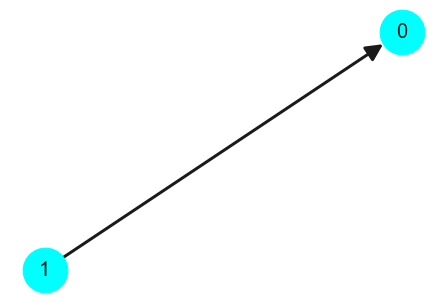

In [81]:
CG3 = nx.algorithms.components.condensation(G3)
nx.draw(CG3, with_labels=True, node_size=2000, font_size=20, width=3, arrowsize=35, node_color='cyan')

print(dict(CG3.nodes))

With this new configuration the two nodes $c$ and $d$ become a **trapping set**.

The **condensation graph** has only **one sink** that is **periodic**. A globabl consensus cannot be reached.

In [82]:
Lambda3 = [
[   0, 2/5, 1/5,   0,   0],
[   0,   0, 3/4, 1/4,   0],
[ 1/2,   0,   0, 1/2,   0],
[   0,   0,   0,   0, 2/3],
[   0,   0,   0, 1/3,   0]
]

In [83]:
# omega_i, sum of the rows of lambda, the rate of the clocks in the second approach.
w3 = np.sum(Lambda3, axis=1) 
# omega_star, the maximum of omega_i
w3_star = np.max(w3) 
# define matrix Q as lambda/omega_star, this is true outside the diagonal.
Q3 = Lambda3/w3_star 
# add the diagonal part, 1 minus the sum of the rows of Q.
Q3 = Q3 + np.diag(np.ones(len(w3))-np.sum(Q3,axis=1))
print('matrix Q3:')
print(Q3)
print()
print(f'Omega w3_i')
print(w3)

matrix Q3:
[[0.4        0.4        0.2        0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.         0.33333333 0.66666667]
 [0.         0.         0.         0.33333333 0.66666667]]

Omega w3_i
[0.6        1.         1.         0.66666667 0.33333333]


In [84]:
# Compute the eigenvalue and the eigenvectors
values3,vectors3 = np.linalg.eig(Q3.T)
#Identify the leading one and we print it.
index3 = np.argmax(values3.real)
# pi_bar is the invariant measure of the CTMC
pi_bar3 = vectors3[:,index3].real
pi_bar3 = pi_bar3/np.sum(pi_bar3)

# Print probability of each state
print("pi_bar3=", pi_bar3)
print()

D3 = np.diag(w3) 
print("D3 =")
print(D3)
print()

P3 = np.linalg.inv(D3) @ Lambda3
print("P3 = ")
print(P3)

pi_bar3= [-3.87129364e-16 -3.17253886e-16 -2.83257036e-16  3.33333333e-01
  6.66666667e-01]

D3 =
[[0.6        0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.        ]
 [0.         0.         0.         0.66666667 0.        ]
 [0.         0.         0.         0.         0.33333333]]

P3 = 
[[0.         0.66666667 0.33333333 0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.         0.         1.        ]
 [0.         0.         0.         1.         0.        ]]


In [85]:
avg_var_init3, avg_var_cons3, init3, cons3 = compute_variance(P3, 800)
print("Initial distribution:", init3)
print("Consensus vector:", cons3)

Initial distribution: [0.45868003 0.46165311 0.2493974  0.46323447 0.73688973]
Consensus vector: [0.5895369  0.5790117  0.67373852 0.46323447 0.73688973]


Since the sink is periodic, the condition required for the French-DeGroot theorem are not satisfied, so a global consensus cannot be reached.

To overcome this problem, we may add self-loops to the node c and d to make the sink aperiodic.

Is G aperiodic: True
Is G strongly connected: False


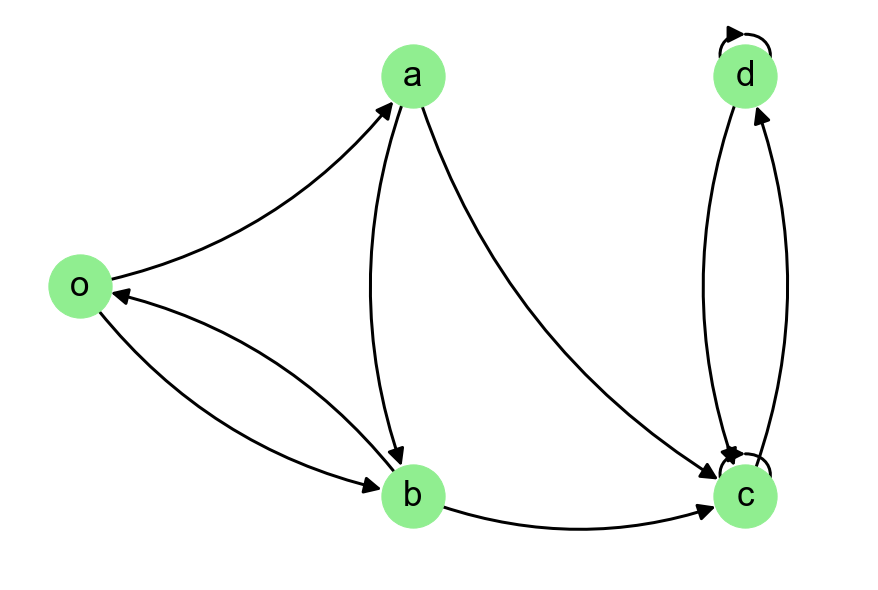

In [86]:
fig = plt.figure(1, figsize=(12,8))

G4 = G3.copy()

G4.add_edge('d', 'd')
G4.add_edge('c', 'c')

print("Is G aperiodic:",nx.is_aperiodic(G4))
print("Is G strongly connected:",nx.is_strongly_connected(G4))

nx.draw(G4, pos, with_labels = True, font_color='black', node_color='lightgreen', 
        edge_color='black', node_size=4000, font_size=35, width=3, arrowsize=35,
        connectionstyle='Arc3, rad = 0.2')

In [87]:
Lambda4 = [
[   0, 2/5, 1/5,   0,   0],
[   0,   0, 3/4, 1/4,   0],
[ 1/2,   0,   0, 1/2,   0],
[   0,   0,   0,   1, 2/3],
[   0,   0,   0, 1/3,   1]
]

# omega_i, sum of the rows of lambda, the rate of the clocks in the second approach.
w4 = np.sum(Lambda4, axis=1) 
# omega_star, the maximum of omega_i
w4_star = np.max(w4) 
# define matrix Q as lambda/omega_star, this is true outside the diagonal.
Q4 = Lambda4/w4_star 
# add the diagonal part, 1 minus the sum of the rows of Q.
Q4 = Q4 + np.diag(np.ones(len(w4))-np.sum(Q4,axis=1))
print('matrix Q4:')
print(Q4)
print()
print(f'Omega w4_i')
print(w4)
print()

# Compute the eigenvalue and the eigenvectors
values4,vectors4 = np.linalg.eig(Q4.T)
#Identify the leading one and we print it.
index4 = np.argmax(values4.real)
# pi_bar is the invariant measure of the CTMC
pi_bar4 = vectors4[:,index4].real
pi_bar4 = pi_bar4/np.sum(pi_bar4)

# Print probability of each state
print("pi_bar4=", pi_bar4)
print()

D4 = np.diag(w4) 
print("D4 =")
print(D3)
print()

P4 = np.linalg.inv(D4) @ Lambda4
print("P4 = ")
print(P4)
print()

avg_var_init4, avg_var_cons4, init4, cons4 = compute_variance(P4, 800)
print("Initial distribution:", init4)
print("Consensus vector:", cons4)

matrix Q4:
[[0.64 0.24 0.12 0.   0.  ]
 [0.   0.4  0.45 0.15 0.  ]
 [0.3  0.   0.4  0.3  0.  ]
 [0.   0.   0.   0.6  0.4 ]
 [0.   0.   0.   0.2  0.8 ]]

Omega w4_i
[0.6        1.         1.         1.66666667 1.33333333]

pi_bar4= [5.84620221e-16 2.28177128e-16 2.07734826e-16 3.33333333e-01
 6.66666667e-01]

D4 =
[[0.6        0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.        ]
 [0.         0.         0.         0.66666667 0.        ]
 [0.         0.         0.         0.         0.33333333]]

P4 = 
[[0.         0.66666667 0.33333333 0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.         0.6        0.4       ]
 [0.         0.         0.         0.25       0.75      ]]

Initial distribution: [0.45864639 0.1430164  0.03273712 0.32709809 0.89259759]
Consensus vector

Now the consensus vector can be reached.

## Problem 2

In this part we will again consider the same network of problem 1. 
However, now we will simulate many particles moving around in the network in continuous time.

Each of the particles in the network will move around just as the single particle moved
around in Problem 1:

The **time** it will stay in a node is **exponentially distributed**, and **on average** it will **stay** $1/\omega_i$ time-units in a node i **before moving to one of its outneighbors**.

The **next node** it will visit is based on the **probability matrix** $ P = diag(\omega)^{-1} \Lambda$ , 
where $\omega = \Lambda 1$.

Your task is to simulate this system from two different perspectives: 

##### 1) Particle perspective



1) the **particle perspective** (i.e. "follow the particle"). 
  
Simulating the system from a particle perspective is exactly as in Problem 1, but here you have to **follow many  particles** instead.

To simulate the particle perspective we could either attach a Poisson clock to each of the
particles and move them individually, just as in Problem 1.

We could have a **single, system-wide Poisson clock with rate 100**. Then, at **every tick** of the system-wide clock we **randomly select which particle to move**.
This **particle** is then **moved to a neighbor node** (which can be itself) based on the **transition probability matrix $Q$**. This means, that if a particle in node o is selected, there is a **probability of 1 - $\omega_o$** = 1-3/5 = 2/5 that it will **stay in node o**, and a **probability of $\omega_o$** = 3/5 that it will **leave the node**.



In [88]:
n_particles = 100
n_steps = 100

def particle_perspective():
    # I create a dictionary with key the number of the particle and as value the node in which the particle is.
    particles = [i for i in range(n_particles)]
    nodes = [1 for i in range(n_particles)]
    net = dict(zip(particles, nodes))
    #print(net)

    # Attach a poisson clock for each particle



    # position array will keep trace of the visited states
    # we create a matrix with:
    # - 100 rows, one per particle
    # - n columns, one per step
    pos = np.zeros([n_particles,n_steps], dtype=int)

    # we start from state a, so we set 1 in the first position of the 100 rows
    # Basically we set the first column to 1 of the matrix
    pos[:,0] = 1

    # transition_times will store the time instants at which jumps/transitions happen
    transition_times = np.zeros([n_particles,n_steps])
    intervals = np.zeros([n_particles], dtype=object)

    # the random time to wait for the next transition is drawn according to its distribution.
    # To model all the Poisson Clock we need just to model the time for the next tick. If we are able to do this,
    # all the clock is modeled. 
    # NOTE: in the formula for t_next we use the rate of the clock of the current state,
    # in this case w[1] because we start from node a.
    t_next = -np.log(np.random.rand())/w[1]

    # The way of computing/extracting the neighboring position the next visited nodes according to the distribution 
    # given by the row of Q.
    P_cum = np.cumsum(P, axis=1)

    for r in range(n_particles):
        for i in range(1,n_steps):
            # the next state to visit will be extracted according to the probabilities
            # stored in the row of P corresponding to the current state.
            # we need to take the number of the node from the current row in the matrix of the position.
            pos[r, i] = np.argwhere(P_cum[pos[r, i-1]] > np.random.rand())[0]
            # store the time instant of the current transition
            transition_times[r, i] = transition_times[r, i-1] + t_next
            # compute the waiting time to the next transition
            # NOTE: we use the rate w[pos[i]] of the clock of the current position
            # we use the clock of position i!
            t_next = -np.log(np.random.rand())/w[pos[r, i]]
        # I compute the differences of interval between the jumps and I store into the intervals list
        intervals[r] = np.diff(transition_times[r,:], n=1, append = transition_times[r,-1] + t_next)
        
    return pos, transition_times, intervals

In [89]:
#print(pos[0])
#ix_a = np.where(pos[0]==1)
#print(ix_a[0][1])

#print(transition_times[0, ix_a[0][1]])
#print(transition_times[0])

In [90]:
pos, transition_times, intervals = particle_perspective()

total_avg = []

for l in range(100000):
    return_times_a_100 = []
    for k in range(n_particles):
        # Find the index where the particle reach node a
        ix_a = np.where(pos[k]==1)
        # Take the second index, since the first index is the origin and we do not want to consider it
        #return_times_a_100.append(transition_times[k, ix_a[0][1]])
        total_avg.append(transition_times[k, ix_a[0][1]])
    #avg_return_time_a_100 = sum(return_times_a_100)/n_particles
    
    
print("Average return time of 100 particles to node a:")
print(sum(total_avg)/len(total_avg))

Average return time of 100 particles to node a:
7.030497872597933


The average time is aligned with the average time found in problem 1.

In [91]:
# Estimate pi

def estimate_pi_particle_perspective():
    pi_estimate_list = []
    pi_estimate = np.zeros(n_nodes)

    for p in range(n_particles):
        for node in range(n_nodes):
            visits = np.argwhere(pos[p, :] == node)
            visits = visits.squeeze().tolist()
            #print(visits)
            #print(intervals[0][visits])
            # I take the sum of the intervals that ends in the node divided by the total time.
            # this gives you an ESTIMATION of PI for that STATE/NODE
            pi_estimate[node] = np.sum(intervals[p][visits])/(transition_times[p,-1])
        #print("Estimate of pi_bar:", pi_estimate)
        pi_estimate_list.append(pi_estimate)

    total = [sum(x) for x in zip(*pi_estimate_list)]
    den = len(pi_estimate_list)
    avg = [x/den for x in total]
    return avg

#print("Average estimate of pi_bar with 100 single particle that start in node a and make 60 steps:")
#print(estimate_pi_particle_perspective())

In [92]:
#I need to do many more experiment to obtain a good average pi_estimation
n_iterations = 100
pi_estimate_list = []
for k in range(n_iterations):
    pos, transition_times, intervals = particle_perspective()
    pi_estimate_list.append(estimate_pi_particle_perspective())
    
pi_estimate_avg = compute_list_avg(pi_estimate_list) 
print("Average estimate of pi_bar with 100 single particle that start in node a:") 
print(pi_estimate_avg)

Average estimate of pi_bar with 100 single particle that start in node a:
[0.17451532224895247, 0.16376694220242718, 0.2192923111748715, 0.2275149839508796, 0.22599343828309817]


The pi estimation is very close to the pi_estimation that we computed at the beginning of problem 1, computing the leading eigenvector of the matrix Q'.

##### 2) Node perspective

2) the **node perspective** (i.e. "observe from the node").
  
To simulate the system from the node perspective you instead have to observe the particles from the node. When doing this you do not have to **care** about each single particle, but only **about the number of particles in the node**.
  
Note that at node i, each particle in that node will stay there on average $1/\omega_i$ time units. Therefore, the node will pass along particles at a rate proportional to the number of particles in the node. 

In fact, if at time $t$ the number of particles in node $i$ is $n_i(t)$, it will pass along particles at a rate of $n_i(t)\omega_i$.

The departure times of the node can thus be seen as a Poisson process with rate $n_i(t)\omega_i$. At each tick of the Poisson clock of the node, it will move a particle to a neighboring node. The node to which the particle will move is again based on the normalized transition rate matrix P.


For the node perspective we could have one Poisson clock attached to each node. But since the rate of this is proportional to the number of particles in the node, it would have to change rate during the simulation. 

An alternative way is to again have a **system-wide Poisson clock with rate 100**. Then, at each tick we randomly, and **proportionally to the number of particles** in the **different nodes**, select a **node** from which we should **move a particle**. Then a **particle** from the **selected node** will move according to the **transition probability matrix Q**.



I select a node and then I apply the probability to move to all the particles in the node

In [93]:
def node_perspective():
    # I create a dictionary with key the number of the nodes and as value the number of particle it contains.
    n_particles = 100
    particles_distrib = [100, 0, 0, 0, 0]

    distrib_o = [100]
    distrib_a = [0]
    distrib_b = [0]
    distrib_c = [0]
    distrib_d = [0]


    nodes_list = [i for i in range(n_nodes)]
    net_nodes = dict(zip(nodes_list, particles_distrib))
    #print(net_nodes)

    n_steps = 6000
    rate = 100
    pos2 = np.zeros([n_particles], dtype=int)


    transition_times = np.zeros([n_particles,n_steps])

    t_next = -np.log(np.random.rand())/rate
    Q_cum = np.cumsum(Q, axis=1)

    for i in range(1, n_steps):
        # I need to select randomly and proportionally to the distribution of the particles a node
        particles_cum_distrib = np.cumsum(particles_distrib)/n_particles
        current_node = np.argwhere(particles_cum_distrib > np.random.rand())[0]
        #print("current node", current_node[0])

        # create a list with the index of the particles in the current node
        ix_particles_current_node = np.where(pos2==current_node[0])[0]
        #print(ix_particles_current_node)

        # Choose randomly a particle between the ones in the list
        selected_particle = choice(ix_particles_current_node, 1)[0]
        #print("selected particle", selected_particle)

        #for selected_particle in ix_particles_current_node:
        
        # Next node according to the transition probability matrix Q
        next_node = np.argwhere(Q_cum[current_node[0]] > np.random.rand())[0]

        #print("next node: ", next_node)

        # Set the new node state for the particle selected
        pos2[selected_particle] = next_node

        # Update the distribution of the particles
        particles_distrib[current_node[0]] -= 1
        particles_distrib[next_node[0]] += 1
            
        distrib_o.append(particles_distrib[0])
        distrib_a.append(particles_distrib[1])
        distrib_b.append(particles_distrib[2])
        distrib_c.append(particles_distrib[3])
        distrib_d.append(particles_distrib[4])

        #print(particles_distrib)
        #print()
    return particles_distrib, distrib_o, distrib_b, distrib_a, distrib_c, distrib_d


#print(node_perspective()[0])

### b.2) Illustrate the simulation above with a plot showing the number of particles in each node during the simulation time.

In [94]:
#np.linspace(1, 6000, 6000).tolist()

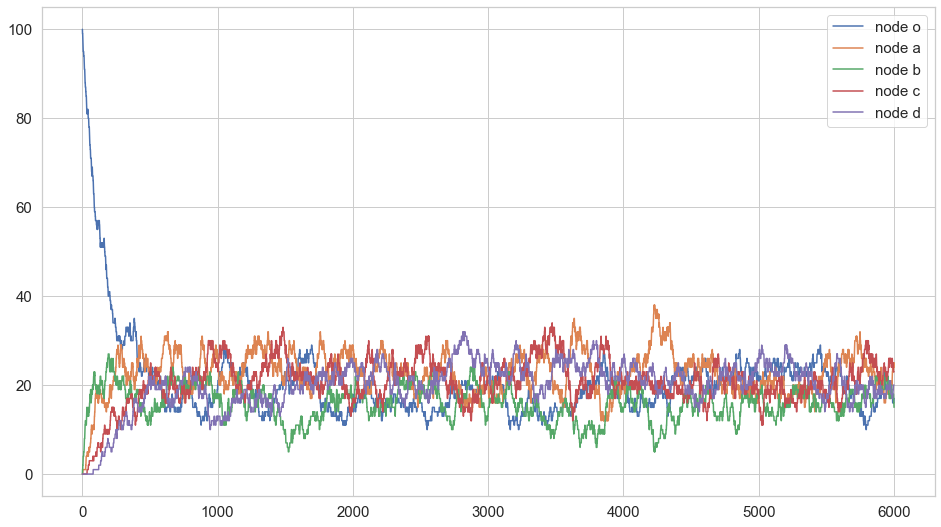

In [95]:
import seaborn as sns
sns.set(style="whitegrid")

fig = plt.figure(1, figsize=(16,9))


x = np.linspace(1, 6000, 6000).tolist()
_, distrib_o, distrib_a, distrib_b, distrib_c, distrib_d = node_perspective()


plt.plot(x, distrib_o, label="node o") 
plt.plot(x, distrib_a, label="node a") 
plt.plot(x, distrib_b, label="node b") 
plt.plot(x, distrib_c, label="node c") 
plt.plot(x, distrib_d, label="node d") 
plt.xticks(size=15)
plt.yticks(size=15)


plt.legend(fontsize=15)
plt.show()

In [96]:
list_partic_distr = []

for i in range(100):
    list_partic_distr.append(node_perspective()[0])

total = [sum(x) for x in zip(*list_partic_distr)]
den = len(list_partic_distr)
avg = [x/den for x in total]

print(avg)

[18.79, 14.93, 21.59, 22.36, 22.33]


This vector shows the average number of particles at the end of 1000 simulations, each one with 60 steps and 100 particles starting from the node o.

## Problem 3

In [4]:
Lambda_open = [
[   0, 2/3, 1/3,   0,   0],
[   0,   0, 1/4, 1/4, 2/4],
[   0,   0,   0,   1,   0],
[   0,   0,   0,   0,   1],
[   0,   0,   0,   0,   1] 
]

# omega_i, sum of the rows of lambda, the rate of the clocks in the second approach.
w_open = np.sum(Lambda_open, axis=1) 
w_star_open = np.max(w_open) # omega star, the maximum of omega_i
Q_open = Lambda_open/w_star_open # define matrix Q as lambda/omega_star, this is true outside the diagonal.
# add the diagonal part, 1 minus the sum of the rows of Q.
Q_open = Q_open + np.diag(np.ones(len(w_open))-np.sum(Q_open,axis=1))

# Compute the eigenvalue and the eigenvectors
values_open,vectors_open = np.linalg.eig(Q_open.T)
#Identify the leading one and we print it.
index_open = np.argmax(values_open.real)
# pi_bar is the invariant measure of the CTMC
pi_bar_open = vectors_open[:,index_open].real
pi_bar_open = pi_bar_open/np.sum(pi_bar_open)

D_open = np.diag(w_open) 

P_open = np.linalg.inv(D_open) @ Lambda_open
P_open_cum = np.cumsum(P_open, axis=1)
print("P", P_open)
print()

print("P_open_cum", P_open_cum)
print()

print("pi_bar_open=", pi_bar_open)

P [[0.         0.66666667 0.33333333 0.         0.        ]
 [0.         0.         0.25       0.25       0.5       ]
 [0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.        ]
 [0.         0.         0.         0.         1.        ]]

P_open_cum [[0.         0.66666667 1.         1.         1.        ]
 [0.         0.         0.25       0.5        1.        ]
 [0.         0.         0.         1.         1.        ]
 [0.         0.         0.         0.         1.        ]
 [0.         0.         0.         0.         1.        ]]

pi_bar_open= [0. 0. 0. 0. 1.]


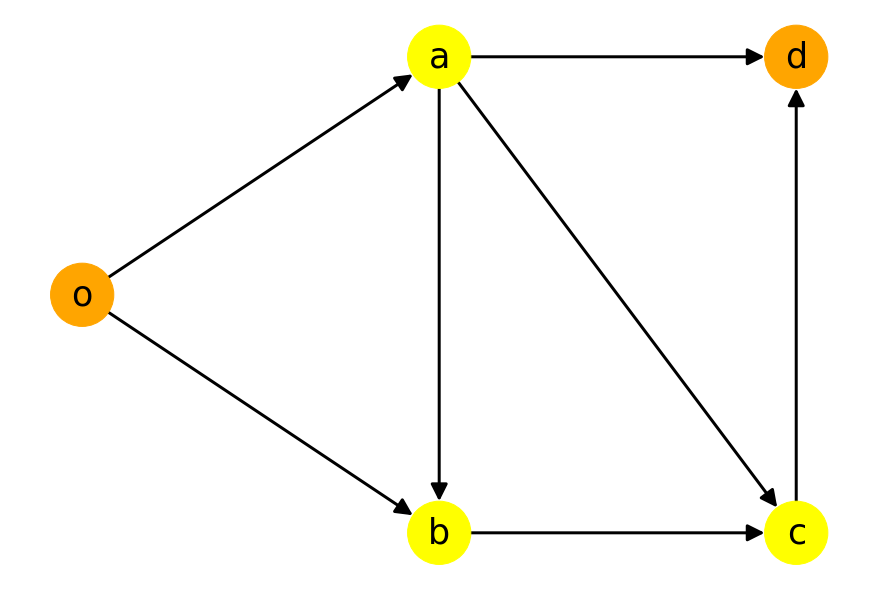

In [5]:
fig = plt.figure(1, figsize=(12,8))

G_open = nx.MultiDiGraph()

G_open.add_node('o')
G_open.add_node('a')
G_open.add_node('b')
G_open.add_node('c')
G_open.add_node('d')

G_open.add_edges_from([('o', 'a'), ('o', 'b'), ('a', 'b'), ('a', 'd'),
                       ('a', 'c'), ('b', 'c'), ('c', 'd')])

pos = {'o':[-2, 0], 'a':[0, 2], 'b':[0, -2], 'c':[2, -2], 'd':[2, 2]}

n_nodes_open = G_open.number_of_nodes()



nx.draw(G_open, pos, with_labels = True, font_color='black', 
        node_color=['orange', 'yellow', 'yellow', 'yellow', 'orange'], 
        edge_color='black', node_size=4000, font_size=35, width=3, arrowsize=35)

### 1) Fixed rate

I want to simulate a Poisson clock with rate = 1 until 60 time units are passed.

In [6]:
time_clicks = []
t = 0
rate=1
while(t<=60):
    t_next = -np.log(np.random.rand())/rate
    time_clicks.append(t)
    t += t_next
    
print(time_clicks)
print(len(time_clicks))

[0, 0.09976977812478866, 0.4308562540256544, 1.8450943806894837, 1.9452418649939585, 2.8787155893834395, 5.97881756966476, 6.45712433019373, 7.023086266673049, 8.85767462929348, 9.030720740198817, 10.878473055676489, 11.954796951337084, 11.96805505493955, 12.156664590740183, 13.493966681954431, 13.75287697887944, 14.308603824942269, 14.32469716627733, 15.71358867945155, 16.7847449093496, 16.810082118005024, 17.16919759105935, 17.702851991464293, 18.075205591135028, 18.649543780531058, 20.096476272291692, 21.223550216739685, 22.1288056716736, 22.2484189098532, 25.640366605556494, 25.75198105845464, 26.711737635982953, 29.220968745872824, 33.63035195043118, 33.68492547727452, 34.2643087990765, 35.268804292509195, 35.7392473325938, 36.38949195925154, 36.5215649292378, 36.70198489445384, 37.5488904770895, 40.259605903180955, 40.542418012321036, 42.6540267362733, 42.76218151694618, 43.02378789036537, 43.863043816398154, 44.66867575352696, 45.69207361234283, 46.270574958835745, 47.2514181413

I can simulate 5 poisson clock, each one with rate 1, for 60 time units, then I can create a dictionary to associate the time instant to each node, then I can create a unique list list of tuple where I order by the time instant.

total_particles_in 61
total_particles_out 50
total particles still in the nodes 11
system_distribution [8, 1, 1, 1, 0]


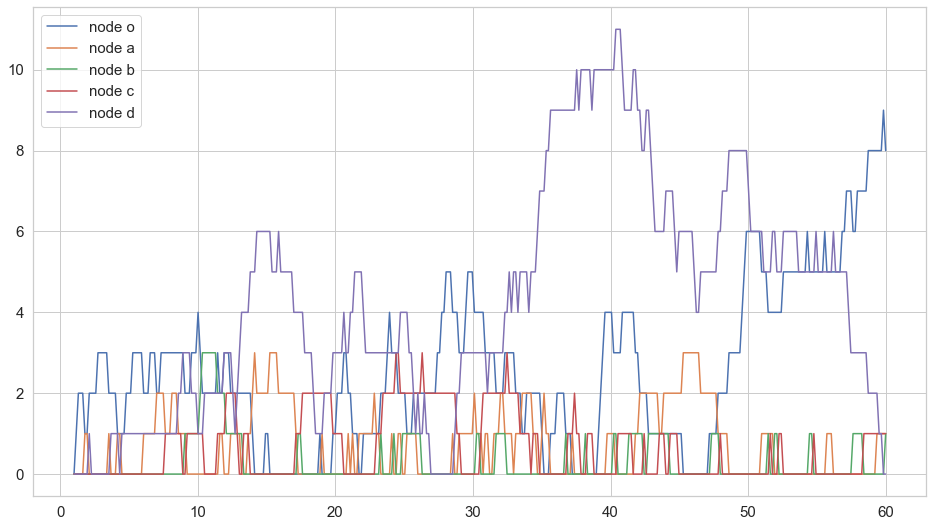

In [7]:
def fixed_rate_poisson(input_rate=1, fixed_rate=1):
    ex_input = []
    node_o = []
    node_a = []
    node_b = []
    node_c = []
    node_d = []

    rate=1

    t = 0
    while(t<=60):
        t_next = -np.log(np.random.rand())/input_rate
        ex_input.append((-1, t))
        t += t_next

    t = 0
    while(t<=60):
        t_next = -np.log(np.random.rand())/fixed_rate
        node_o.append((0, t))
        t += t_next

    t = 0
    while(t<=60):
        t_next = -np.log(np.random.rand())/fixed_rate
        node_a.append((1, t))
        t += t_next

    t = 0
    while(t<=60):
        t_next = -np.log(np.random.rand())/fixed_rate
        node_b.append((2, t))
        t += t_next

    t = 0
    while(t<=60):
        t_next = -np.log(np.random.rand())/fixed_rate
        node_c.append((3, t))
        t += t_next

    t = 0
    while(t<=60):
        t_next = -np.log(np.random.rand())/fixed_rate
        node_d.append((4, t))
        t += t_next

    global_ticks_node = []    

    for ix, node in enumerate([ex_input, node_o, node_a, node_b, node_c, node_d]):
        for elem in node:
            global_ticks_node.append(elem)

    #global_ticks_node

    global_ticks_node_sorted = sorted(global_ticks_node, key=lambda x : x[1])
    #print(global_ticks_node_sorted)

    system_distribution = [0,0,0,0,0]
    total_particles_in = 0
    total_particles_out = 0
    o = []
    a = []
    b = []
    c = []
    d = []

    for value in global_ticks_node_sorted:
        #print("node", value[0], "time click", value[1])
        if value[1] > 0:

            # a particle enters in the system
            if node == -1:
                system_distribution[0] += 1
                total_particles_in += 1
            #print(system_distribution)

            # I take the value of the node
            node = value[0]

            # I check the presence of particle in the node
            if system_distribution[node] > 0:

                # or I am in the node d, so I decrease of 1 particle
                if node == 4:
                    system_distribution[node] -= 1  
                    total_particles_out +=1
                # or I have particles in the node, I can move one to the neighbors
                else:
                    neighbor = np.argwhere(P_open_cum[node] > np.random.rand())[0]
                    system_distribution[node] -= 1
                    system_distribution[neighbor[0]] += 1

            o.append(system_distribution[0])
            a.append(system_distribution[1])
            b.append(system_distribution[2])
            c.append(system_distribution[3])
            d.append(system_distribution[4])
        
    return total_particles_in, total_particles_out, system_distribution, o, a, b, c, d

total_particles_in, total_particles_out, system_distribution, o, a, b, c, d = fixed_rate_poisson()

print("total_particles_in", total_particles_in)
print("total_particles_out", total_particles_out)
print("total particles still in the nodes", total_particles_in-total_particles_out)
print("system_distribution", system_distribution)
                
import seaborn as sns
sns.set(style="whitegrid")

fig = plt.figure(1, figsize=(16,9))


x = np.linspace(1, 60, len(o)).tolist()


plt.plot(x, o, label="node o") 
plt.plot(x, a, label="node a") 
plt.plot(x, b, label="node b") 
plt.plot(x, c, label="node c") 
plt.plot(x, d, label="node d") 
plt.xticks(size=15)
plt.yticks(size=15)


plt.legend(fontsize=15)
plt.show()

In [8]:
# We simulated the average number of particles per node in the system with input Poisson rate = 1 
# and Poisson rate per each node fixed to 1

total_system_distribution = []

for i in range(1000):
   
    total_system_distribution.append(fixed_rate_poisson()[2])

total = [sum(x) for x in zip(*total_system_distribution)]
den = len(total_system_distribution)
avg = [x/den for x in total]

print(avg)

[7.857, 1.519, 0.781, 1.568, 4.835]


In [9]:
# We simulated the average number of particles per node in the system with input Poisson rate = 1 
# and Poisson rate per each node fixed to 1

def simulate_fixed_rated_poisson(input_rate):
    
    total_system_distribution = []

    for r in input_rate:
        
        for i in range(1000):
            total_system_distribution.append(fixed_rate_poisson(r,1)[2])

        total = [sum(x) for x in zip(*total_system_distribution)]
        den = len(total_system_distribution)
        avg = [x/den for x in total]
        
        print("input rate: ", r)
        print("Final particles distribution: ", avg)

In [10]:
input_rates = np.arange(1.0, 3.0, 0.1).tolist()
simulate_fixed_rated_poisson(input_rates)

input rate:  1.0
Final particles distribution:  [8.378, 1.562, 0.84, 1.519, 4.638]
input rate:  1.1
Final particles distribution:  [10.138, 1.62, 0.8515, 1.6555, 4.993]
input rate:  1.2000000000000002
Final particles distribution:  [12.134333333333334, 1.7063333333333333, 0.883, 1.668, 5.272333333333333]
input rate:  1.3000000000000003
Final particles distribution:  [14.22725, 1.75075, 0.9235, 1.73, 5.5415]
input rate:  1.4000000000000004
Final particles distribution:  [16.6104, 1.807, 0.946, 1.7438, 5.7522]
input rate:  1.5000000000000004
Final particles distribution:  [19.044333333333334, 1.8303333333333334, 0.9595, 1.7653333333333334, 5.942]
input rate:  1.6000000000000005
Final particles distribution:  [21.73857142857143, 1.8674285714285714, 0.966, 1.7795714285714286, 6.035]
input rate:  1.7000000000000006
Final particles distribution:  [24.50725, 1.87375, 0.974, 1.772, 6.134375]
input rate:  1.8000000000000007
Final particles distribution:  [27.302222222222223, 1.887, 0.9735555555

### 2) Proportional rate

I create a function where I pass the input rate of the Possion process, that need to be proportional to the number of particles in the node, then I pass the final time that I want to reach, then I pass the time for each node from which I have to start based on the previous Poisson clock.

In [11]:
# How can I handle a situation where I have 0 particles in my node
# so the extimated t_next is almost infinite, but I want to keep
# updating the clock until I reach the time unit 60?
# I return 0 as t_next
def poisson_rate_custom(input_rate):
    eps = 10**-10
    if(input_rate == 0):
        return 0
    t_next = -np.log(np.random.rand())/(input_rate+eps) 
    return t_next

def sorting_func(to_sort):
    return sorted(to_sort.items(), key=lambda x : x[1])

In [12]:
def proportional_rate_poisson(t_final):
    system_distribution = [0,0,0,0,0]
    total_particles_in = 0
    total_particles_out = 0
    last_node_clicks_situation = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    current_nodes_clicks = {-1:0.0, 0:0.0, 1:0.0, 2:0.0, 3:0.0, 4:0.0}
    #input_node_clicks_situation = 0
    
    time_o = 0
    time_a = 0
    time_b = 0
    time_c = 0
    time_d = 0
    
    o = []
    a = []
    b = []
    c = []
    d = []
    
    # Initial condition, exogenous poisson rate of 1, the other very close to 0 but not exatcly zero to avoid
    # the division by zero.
    
    input_cond = True
    node_o_cond = True
    node_a_cond = True 
    node_b_cond = True 
    node_c_cond = True
    node_d_cond = True
    
    # When 60 time units are passed from the beginning of the input rate I stop it
    while input_cond:
        print("input code", input_cond)
        
        
        t_input = poisson_rate_custom(1)  
        print(last_node_clicks_situation[0] + t_input)
        if last_node_clicks_situation[0] + t_input <= 60:
            print("input true")
            last_node_clicks_situation[0] += t_input
            #last_situation(current_nodes_clicks, ex_input)
        elif last_node_clicks_situation[0] > 0:
            print("input false")
            input_cond = False

        
        #print("input_node_clicks_situation", input_node_clicks_situation)
        
        #print("system_distribution node o: ", system_distribution[0])
        t_o = poisson_rate_custom(system_distribution[0])
        print(t_o)
        print("last_node_clicks_situation[1] + t_o ", last_node_clicks_situation[1] + t_o)
        if last_node_clicks_situation[1] + t_o <= 60:
            print("o true")
            last_node_clicks_situation[1] += t_o
            #last_situation(current_nodes_clicks, node_o)
        # Poisson clock has started
        #elif last_node_clicks_situation[1] > 0:
        #    print("o false")
        #    node_o_cond = False
        
        t_a = poisson_rate_custom(system_distribution[1])
        print("last_node_clicks_situation[2] + t_a ", last_node_clicks_situation[2] + t_a)
        if last_node_clicks_situation[2] + t_a <= 60:
            print("a true")            
            last_node_clicks_situation[2] += t_a
        #elif last_node_clicks_situation[2] > 0:
        #    print("a false")               
        #    node_a_cond = False
            
        t_b = poisson_rate_custom(system_distribution[2])
        print("last_node_clicks_situation[3] + t_b ", last_node_clicks_situation[3] + t_b)
        if last_node_clicks_situation[3] + t_b <= 60:
            print("b true")            
            last_node_clicks_situation[3] += t_b
        #elif last_node_clicks_situation[3] > 0:
        #    print("b false")               
        #    node_b_cond = False
            
        t_c = poisson_rate_custom(system_distribution[3])
        print("last_node_clicks_situation[4] + t_c ", last_node_clicks_situation[4] + t_c)
        if last_node_clicks_situation[4] + t_c <= 60:
            print("c true")            
            last_node_clicks_situation[4] += t_c
        #elif last_node_clicks_situation[4] > 0:
        #    print("c false")               
        #    node_c_cond = False
        
        t_d = poisson_rate_custom(system_distribution[4])
        print("last_node_clicks_situation[5] + t_d ", last_node_clicks_situation[5] + t_c)
        if last_node_clicks_situation[5] + t_d <= 60:
            print("d true")            
            last_node_clicks_situation[5] += t_d
        #elif last_node_clicks_situation[5] > 0:
        #    print("d false")               
        #    node_d_cond = False        


        current_nodes_clicks[-1] = last_node_clicks_situation[0]
        current_nodes_clicks[0] = last_node_clicks_situation[1]
        current_nodes_clicks[1] = last_node_clicks_situation[2]
        current_nodes_clicks[2] = last_node_clicks_situation[3]
        current_nodes_clicks[3] = last_node_clicks_situation[4]
        current_nodes_clicks[4] = last_node_clicks_situation[5]
        
        #last_situation(current_nodes_clicks, ex_input, node_o, node_a, node_b, node_c, node_d)
        #print(current_nodes_clicks)

        # I need to sort the last situation in the network
        current_nodes_clicks_sorted = sorting_func(current_nodes_clicks)
        #print(sorting_func(current_nodes_clicks))

        # At this point I iterate over all the node in the last situation 
        # and move the particles
        print("system distr before while", system_distribution)
        for v in current_nodes_clicks_sorted:

            node = v[0]
            click = v[1]

            if node > -1:
                print("node: ", node, "rate used: ", system_distribution[node])
            else:
                print("node: ", node, "rate used: ", 1)
            #print("click: ", click)

            # a particle enters in the system
            if node == -1:
                system_distribution[0] += 1
                total_particles_in += 1

            # I check the presence of particle in the node
            if system_distribution[node] > 0.000001:

                # or I am in the node d, so I decrease of 1 particle
                if node == 4:
                    system_distribution[node] -= 1  
                    total_particles_out +=1
                else:               
                    # or I have particles in the node, I can move one to the neighbors
                    neighbor = np.argwhere(P_open_cum[node] > np.random.rand())[0]
                    system_distribution[node] -= 1
                    system_distribution[neighbor[0]] += 1

        # at the end of the for I have to compute the new last situation and compute the next clicks
        # until all the Poisson clocks reach the 60 time units
            print(system_distribution)
            #print(last_node_clicks_situation)
        print(current_nodes_clicks)
        print()
    
    
proportional_rate_poisson(60)

input code True
0.8730459811053751
input true
0
last_node_clicks_situation[1] + t_o  0.0
o true
last_node_clicks_situation[2] + t_a  0.0
a true
last_node_clicks_situation[3] + t_b  0.0
b true
last_node_clicks_situation[4] + t_c  0.0
c true
last_node_clicks_situation[5] + t_d  0.0
d true
system distr before while [0, 0, 0, 0, 0]
node:  0 rate used:  0
[0, 0, 0, 0, 0]
node:  1 rate used:  0
[0, 0, 0, 0, 0]
node:  2 rate used:  0
[0, 0, 0, 0, 0]
node:  3 rate used:  0
[0, 0, 0, 0, 0]
node:  4 rate used:  0
[0, 0, 0, 0, 0]
node:  -1 rate used:  1
[1, 0, 0, 0, 0]
{-1: 0.8730459811053751, 0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0}

input code True
1.6439847618124128
input true
0.058638903292805605
last_node_clicks_situation[1] + t_o  0.058638903292805605
o true
last_node_clicks_situation[2] + t_a  0.0
a true
last_node_clicks_situation[3] + t_b  0.0
b true
last_node_clicks_situation[4] + t_c  0.0
c true
last_node_clicks_situation[5] + t_d  0.0
d true
system distr before while [1, 0, 0, 0, 0]
nod

last_node_clicks_situation[4] + t_c  7.586609691301616
c true
last_node_clicks_situation[5] + t_d  8.920039684436977
d true
system distr before while [1, 1, 0, 1, 2]
node:  3 rate used:  1
[1, 1, 0, 0, 3]
node:  4 rate used:  3
[1, 1, 0, 0, 2]
node:  2 rate used:  0
[1, 1, 0, 0, 2]
node:  -1 rate used:  1
[2, 1, 0, 0, 2]
node:  1 rate used:  1
[2, 0, 0, 0, 3]
node:  0 rate used:  2
[1, 0, 1, 0, 3]
{-1: 20.355801391089617, 0: 24.216554241628593, 1: 22.29867719981844, 2: 10.224087998759666, 3: 7.586609691301616, 4: 8.947347512778776}

input code True
21.030082254873097
input true
3.2962685450828864
last_node_clicks_situation[1] + t_o  27.512822786711478
o true
last_node_clicks_situation[2] + t_a  22.29867719981844
a true
last_node_clicks_situation[3] + t_b  10.735358492326583
b true
last_node_clicks_situation[4] + t_c  7.586609691301616
c true
last_node_clicks_situation[5] + t_d  8.947347512778776
d true
system distr before while [1, 0, 1, 0, 3]
node:  3 rate used:  0
[1, 0, 1, 0, 3]
nod

c true
last_node_clicks_situation[5] + t_d  15.530896745190041
d true
system distr before while [1, 1, 1, 0, 2]
node:  4 rate used:  2
[1, 1, 1, 0, 1]
node:  2 rate used:  1
[1, 1, 0, 1, 1]
node:  3 rate used:  1
[1, 1, 0, 0, 2]
node:  1 rate used:  1
[1, 0, 0, 0, 3]
node:  -1 rate used:  1
[2, 0, 0, 0, 3]
node:  0 rate used:  2
[1, 0, 1, 0, 3]
{-1: 41.89296132768896, 0: 59.55620253912352, 1: 34.96260617052655, 2: 16.85911862620758, 3: 21.59032179427503, 4: 15.632698012636327}

input code True
41.8996593967029
input true
0.17524107565627517
last_node_clicks_situation[1] + t_o  59.73144361477979
o true
last_node_clicks_situation[2] + t_a  34.96260617052655
a true
last_node_clicks_situation[3] + t_b  17.665150217725955
b true
last_node_clicks_situation[4] + t_c  21.59032179427503
c true
last_node_clicks_situation[5] + t_d  15.632698012636327
d true
system distr before while [1, 0, 1, 0, 3]
node:  4 rate used:  3
[1, 0, 1, 0, 2]
node:  2 rate used:  1
[1, 0, 0, 1, 2]
node:  3 rate used:  

In [13]:
z = {-1:0.0, 0:0.0, 1:0.0, 2:0.0, 3:0.0, 4:0.0}

In [14]:
z

{-1: 0.0, 0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0}

In [15]:
z = 10**-10
print(z)

1e-10
